## Lab 8 Part I: Contoured Surface Data
<br /><br />

In this week's tutorial, we wish to contour surface data to help us identify fronts.  The plots we will create in this part of the lab will have station plots of observations along with isobars, isotherms, and color-filled isodrosotherms.
<br />
### Module Documentation
1. Matplotlib Pyplot: https://matplotlib.org/stable/api/_as_gen/matplotlib.pyplot.html
2. Caropy crs: https://scitools.org.uk/cartopy/docs/latest/reference/crs.html
3. Cartopy Feature: https://scitools.org.uk/cartopy/docs/latest/matplotlib/feature_interface.html
4. Matplotlib Colors: https://matplotlib.org/stable/gallery/color/named_colors.html
5. Matplotlib Contour: https://matplotlib.org/stable/api/_as_gen/matplotlib.pyplot.contour.html
6. Matplotlib Contourf: https://matplotlib.org/stable/api/_as_gen/matplotlib.pyplot.contourf.html
7. Matplotlib Color Maps: https://matplotlib.org/stable/tutorials/colors/colormaps.html
8. Scipy Gaussian Filter: https://docs.scipy.org/doc/scipy/reference/generated/scipy.ndimage.gaussian_filter.html
9. Scipy Griddata function: https://docs.scipy.org/doc/scipy/reference/generated/scipy.interpolate.griddata.html
10. MetPy Units: https://unidata.github.io/MetPy/latest/tutorials/unit_tutorial.html



If you have any questions about the code below, feel free to reach out to me at mpvossen@uwm.edu. I am always willing to further explain the code. <br /> <br />

---

<br />
1. As usual, we start by importing the modules we need for our Python code.

In [1]:
#from the data reading capabilities of metpy (metpy.io) import the METAR reading capability (parse_metar_file)
from metpy.io import parse_metar_file

#from the dates and time code(datetime), import the date and time reading capabilities (datetime)
from datetime import datetime

#import the module to download files from the internet
import requests

#from the interpolate sub module of the scipy module, import the griddata function.  This is what we use to create gridded data.
from scipy.interpolate import griddata

#from metpy's plotting abilities (metpy.plots) import the abilities to create a station plot (StationPlot) and the sky cover symbols (sky_cover)
from metpy.plots import StationPlot, sky_cover

#import the numpy module and save it to the variable np
import numpy as np

#import the cartopy (cartopy) module's coordinate reference system (.crs) and save it to the variable crs
import cartopy.crs as crs

#import the cartopy (cartopy) module's ability to plot geographic data (.feature) and save it to the variable cfeature 
import cartopy.feature as cfeature

#import the pyplot submodule from the matplotlib module and save it to the variable plt
import matplotlib.pyplot as plt

#from the metpy calculations module, import the reduce_point_density function
from metpy.calc import reduce_point_density

#from the ndimage submodule within the scipy module, import the gaussian_filter function
from scipy.ndimage import gaussian_filter

#from metpy's units capabilities, import the units class
from metpy.units import units

#import the module sys
import sys

#this line declares that we would like to look for modules outside the default location.  Here I specify the extra modules directory 
#within the shared_notebook space for synoptic I.
sys.path.insert(0, '/srv/data/shared_notebooks/Synoptic1-AtmSci360/Extra_Modules/')

#from the min_max module import the plot_maxmin_points function
from min_max import plot_maxmin_points

#from the iowa_metar module import the download_alldata function
from iowa_metar import download_alldata

<br /><br />
2. As with past labs, we place our data-processing code into a function.  Use the code block below to create your data processing function, following the instructions contained in the comments.

In [2]:
"""
INPUT:
    time : DATETIME
        The time for which you would like surface data.
    
OUTPUT:
    metar_data : PANDAS DATAFRAME
        Dataframe containing processed METAR data
    new_pressure : NUMPY ARRAY
        Gridded sea-level pressure data
    new_temperature : NUMPY ARRAY
        Gridded surface temperature data
    new_dewpoint : NUMPY ARRAY
        Gridded surface dewpoint temperature data
    new_lat : NUMPY ARRAY
        Latitude values corresponding with the gridded sea-level pressure data
    new_lon : NUMPY ARRAY
        Longitude values corresponding with the gridded sea-level pressure data
    proj : CRS OBJECT
        The projection to use for your map

"""


def process_surface_data(time):
    """
    Using the iowa_metar module's download_alldata function, we download the METAR observations for the time we have specified.
    The resulting output will be a StringIO object (like we worked with in Lab 3) that contains the raw METAR data. 
    """
    data_file = download_alldata(time)
    
    
    """
    As in Lab 5, setup metpy's METAR parsing function to parse out the data we retrieved from Iowa State (data_file).
    """
    metar_data = parse_metar_file(data_file, month = time.month, year=time.year)
    
    
    """
    As in previous labs, we need to convert our units from the default METAR units to our desired units.
    In the section below convert the temperature, dewpoint, and wind data to the appropriate imperial
    units.
    """
    temps = metar_data["air_temperature"].values * units.degC
    metar_data["air_temperature"] = temps.to(units.degF)
    
    dewpoint=metar_data["dew_point_temperature"].values*units.degC
    metar_data["dew_point_temperature"]=dewpoint.to(units.degF)

    uwind=metar_data["eastward_wind"].values* units.kt
    metar_data["eastward_wind"]
    vwind=metar_data["northward_wind"].values*units.kt
    metar_data["eastward_wind"]
    
    """
    Before we reduce the observation density like we did in Lab 3, we need to grid the data.
    
    The first step to gridding is to define the latitude and longitude grids for each point in our gridded data.
    In the code below use the numpy arange function to define a grid that has longitude values between 130°W to 60°W with a 
    resolution of 0.1°(~9 km) and latitudes ranging from 22°N to 65°N at a resolution of 0.1° (11 km).  Note that the 
    np.arange function includes needs an extra increment to the end value since Python does not include the ending value 
    when creating the list.
    """
    new_lon = np.arange(-130,-59.9,0.1)
    new_lat = np.arange(22,65.1,0.1)
    
    
    
    
    """
    Again as in Lab 3, we need to drop any missing values that are in the latitude and longitude arrays. 
    Remove the observations that have are missing latitude and/or longitude.
    """
    metar_data = metar_data.dropna(how='any', subset=['latitude', 'longitude'])
    

    """
    Next, we grid the sea-level pressure so we can contour it later. However, not all METAR observations have sea-level pressure included.
    To start, we need to remove all observations with missing sea-level pressure.
    
    In the code below, remove all stations with missing sea-level pressure.  Save this to a different variable name from the 
    rest of the METAR data since we are not selective on the METAR data we plot in our station plots.  We will have to do this step 
    separately for each variable we wish to isopleth.
    """
    pres_data =  metar_data.dropna(how='any',subset=['air_pressure_at_sea_level'])
    

    
    """
    We now need to retrieve the latitude and longitude data from our METAR stations that have pressure data.  
    Using the METAR data we separated out above, select the latitude and longitude values like we did in Lab 5 Part I.
    """
    pres_latitude = pres_data['latitude'].values 
    pres_longitude = pres_data['longitude'].values
    
    
    """
    Since we want to grid the sea-level pressure, we need to pull the sea-level pressure values.
    """
    
    metar_slp = pres_data['air_pressure_at_sea_level'].values
    
    
    
    """
    In this lab, we are also going to contour temperature and dewpoint. 
    In the code section below, repeat the preparation steps we completed in the code above for sea-level pressure, 
    except here for temperature and dewpoint.
    """
    
    temp_data =metar_data.dropna(how='any',subset=['air_temperature'])
    
    dewpoint_data=metar_data.dropna(how='any',subset=['dew_point_temperature'])
    
    temp_latitude =temp_data['latitude'].values
    temp_longitude =temp_data['longitude'].values 
    
    dewpoint_latitude = dewpoint_data['latitude'].values 
    dewpoint_longitude =dewpoint_data['longitude'].values
    
    metar_temp =temp_data['air_temperature'].values
    metar_dewpoint =dewpoint_data['dew_point_temperature'].values
    
    
    
    
    
    
    
        
    """
    We are now ready to grid our data using scipy's griddata function.  
    In the function below, the first argument ((pres_longitude, pres_latitude)) is the METAR station latitude and longitude values.
    The second argument (metar_slp) is the sea-level pressure for each METAR station.  
    The third argument ((new_lon[None,:], new_lat[:,None])) is the grid's latitude and longitude values.  The indexing done to the grid
    latitude and longitude values is to take the new longitude and latitude values and arrange them so they match their dimension.  
    In this sense, new_lat[:,None] arranges the latitude values in a vertical list with the largest values at the top and new_lon[None, :]
    arranges the longitude values in a horizontal list with the largest values on the right side.
    The fourth argument (method='linear') is the method used to grid the data.  Here linear is used as a simple method to interpolate the
    value at each grid.  You can also use the "nearest" option or the "cubic" option.
    """
    new_pressure = griddata((pres_longitude, pres_latitude), metar_slp, (new_lon[None,:], new_lat[:,None]), method='linear')
    
    """
    Grid the temperature and dewpoint data using the filtered METAR data we created before.
    """
    new_temperature =griddata((temp_longitude, temp_latitude), metar_temp, (new_lon[None,:], new_lat[:,None]), method='linear')
    new_dewpoint =griddata((dewpoint_longitude, dewpoint_latitude), metar_dewpoint, (new_lon[None,:], new_lat[:,None]), method='linear')
    

    """
    As in Lab 4's Part I, we can apply a Gaussian filter to smooth the potentially noisy surface data.  Surface observations tend to have a lot of small-scale 
    variability, so that plotting the raw data without smoothing will create a plot with a lot of jagged lines.
    
    In the lines below, apply a guassian_filter to the gridded temperature, dewpoint, and sea-level pressure data.  For these data, a sigma value 
    of 6 is needed for all of the variables.
    """
    new_pressure = gaussian_filter(new_pressure, 13)
    new_temperature = gaussian_filter(new_temperature,13)
    new_dewpoint = gaussian_filter(new_dewpoint, 13)
    
    
    
    """
    Setup a Lambert Conformal Conic Projection centered at 35°N and 95°W.  Have the cone of the Lambert Conformal Conic projection intersect the Earth at 27.5°N and 42.5°N.
    """
    proj = crs.LambertConformal(central_longitude=-95, central_latitude=35, standard_parallels=[27.5,42.5])
    
    
    
    """
    Now that we have specified the projection, let's convert the points from the latitude and longitude coordinate system to a coordinate system that works with the projection
    we just specified.  
    """
    point_locs = proj.transform_points(crs.PlateCarree(), metar_data['longitude'].values,metar_data['latitude'].values)
    
    
    
    """
    Now that the data are gridded, we can thin our point observations.  
    In this case, a spacing radius of 100 km is needed.
    """
    metar_data = metar_data[reduce_point_density(point_locs, 100000.)]
    
    
    
    """
    Finally, we return the processed data.
    """
    return metar_data, new_pressure, new_temperature, new_dewpoint, new_lat, new_lon, proj


<br /><br />
3. Call your data processing function to get data for April 13, 2018 at 1200 UTC.

In [3]:
time=datetime(2018,4,13,12)
metar_data, new_pressure,new_temperature, new_dewpoint,new_lat,new_lon, proj = process_surface_data(time)

Downloading: 2018-04-13 12:00:00


<br /><br />
4. Now we are ready to create our plotting function.  In the code below, follow the comments to create a function that plots the observations in station plots, isobars (as lines), isotherms (as lines), and isodrosotherms (as color-filled regions).

In [6]:
"""
Below, I define a function to plot surface data in station-model format with
multiple contoured fields using the gridded data defined above.

INPUT:

    raw_data : PANDAS DATAFRAME
        The dataframe containing the METAR data
    date : DATETIME
        The time for which the plot is valid
    pressure_grid : NUMPY ARRAY
        The gridded pressure data
    temperature_grid : NUMPY ARRAY
        The gridded temperature data
    dewpoint_grid : NUMPY ARRAY
        The gridded dewpoint data
    lat_grid : NUMPY ARRAY
        Latitude values corresponding with the gridded sea-level pressure data
    lon_grid : NUMPY ARRAY
        Longitude values corresponding with the gridded sea-level pressure data
    proj : CRS OBJECT
        The projection you are going to use for your map
    loc : STRIMG
        Location of the plot.  Options are "TX" for a Texas centered map or None for a Midwest centered map.

"""

def plot_surface(raw_data, date, pressure_grid, temperature_grid, dewpoint_grid, lat_grid, lon_grid, proj, loc=None):

    
    """
    Create a figure with a size of 1150px x 800px and a resolution of 300 dots per inch,
    then set up an axes object (named ax) using the projection we previously defined for our map.
    """
    fig = plt.figure(figsize=(11.5,8),dpi=300)
    ax = plt.subplot(projection = proj)
    
    """
    Add the appropriate amount of geographic data.  Be sure you follow "good map" suggestions with the geographic data styling.
    """

    ax.add_feature(cfeature.LAND.with_scale('50m'), edgecolor = "black", facecolor='none',  linewidth=0.75, zorder=2)
    ax.add_feature(cfeature.BORDERS.with_scale('50m'), edgecolor = "black",  facecolor='none', linewidth=0.75, zorder=2)
    ax.add_feature(cfeature.STATES.with_scale('50m'), edgecolor = "grey", linestyle=":", facecolor='none', linewidth=0.5, zorder=1)
    
    
    """
    We are going to create two different plots that focus on two different areas.  Here, I create an option for
    the user to define an area by a string to preset extents that I have defined.  Two extents are defined: a special option 
    for a plot centered on Texas and a default extent that centers on the Midwest.
    """
    if loc == "TX":
        ax.set_extent([-110,-80,25,45], crs=crs.PlateCarree())
    else:
        ax.set_extent([-105,-75,32,55], crs=crs.PlateCarree())
    
    
    """
    Set up the station-model plots.
    """
    stationplot = StationPlot(ax, metar_data['longitude'].values, metar_data['latitude'].values,
                              clip_on=True, transform=crs.PlateCarree(), fontsize=7)
    
    """
    Add temperature, dewpoint, wind, sea-level pressure, and sky coverage to the station plot in their appropriate locations with appropriate formatting.
    Make sure that the data displayed in your station plot are clear and easy to read.
    """
    stationplot.plot_parameter('NW', metar_data['air_temperature'].values, color='red')
    stationplot.plot_parameter('SW', metar_data["dew_point_temperature"].values,color='darkgreen')
    stationplot.plot_parameter('NE', metar_data['air_pressure_at_sea_level'].values,
                           formatter=lambda v: format(10 * v, '.0f')[-3:])
    stationplot.plot_symbol('C', metar_data['cloud_coverage'].values, sky_cover)
    stationplot.plot_barb(metar_data['eastward_wind'].values, metar_data['northward_wind'].values,zorder=10)
    
    """
    Next, add sea-level pressure and temperature line contours using the gridded data we created earlier.  Add styling information 
    to make the contours easier to read.
    """
    cont_p = plt.contour(lon_grid, lat_grid, pressure_grid, np.arange(0,2000,4),linewidths=0.5,colors='k',transform=crs.PlateCarree(),extend="max")
    cont_t = plt.contour(lon_grid, lat_grid, temperature_grid, np.arange(30,70,4),linewidths=0.5,colors='r',transform=crs.PlateCarree(),extend="max")
    
    """
    All plots must label their line contours.  Add contour labels to your line contours.  Add styling information to make the contours easier to read.    
    """
    ax.clabel(cont_p, cont_p.levels, fmt=lambda v: format(v, '.0f'), fontsize=10)
    ax.clabel(cont_t, cont_t.levels, fmt=lambda v: format(v, '.0f'), fontsize=13)
    
    """
    We are now ready to add the color-filled contours for dewpoint.  In the color-filled contour statement below, add a colormap and styling information.
    Be sure to follow the "good map" guidelines in your colormap and styling choices.
    """
    cont_d = plt.contourf(lon_grid, lat_grid, dewpoint_grid, np.arange(60,85,5), cmap='Greens', transform=crs.PlateCarree(), extend="max")
    
    
    """
    Any time a color-filled contour is used, we must have a color bar to display what the colors mean.  
    A color bar is defined in the section below.  Add styling information to make this color bar informative.
    """
    cbar = plt.colorbar(cont_d)   
    cbar.set_label(label="dewpoint Farenheit")
    
    

    
    """
    Let's add symbols denoting minima (lows) and maxima (highs) in the gridded sea-level pressure data.
    The function below takes our gridded data, finds the minimum and maximum points, and then plots
    the appropriate symbols with their values.
    
    The first argument is our axes variable.
    The second and third arguments are our longitude and latitude variables, respectively.
    The fourth argument is our gridded sea-level pressure data.
    The fifth argument indicates if we are looking for lows (min) or highs (max).
    The sixth argument indicates how much of a spatial buffer to use when searching for highs and lows.  The function will be more sensitive to smaller-
    scale highs and lows (thus leading to more highs and lows being plotted) when this value is smaller. The opposite is true when this value is larger.
    You will have to experiment with different values to find one that displays the appropriate amount of highs and lows (i.e., reflecting synoptic-scale
    features) rather than every high and low point in the data.
    The seventh argument is the size of the high or low symbols.
    The final argument is the data's coordinate system.
    """
    plot_maxmin_points(ax, lon_grid, lat_grid, pressure_grid, "min", 100, textsize=20, transform=crs.PlateCarree())
    plot_maxmin_points(ax, lon_grid, lat_grid, pressure_grid, "max", 100, textsize=20, transform=crs.PlateCarree())
    
    
    """
    Finally, add an appropriate title for the map that shows what is plotted and the time at which the map is valid.
    """
    plt.title(f"Surface level Observations at {time:%m/%d/%Y %H%M} UTC",size=9,loc="right")
   
    plt.show()   
    


<br /><br />
5. Call your plotting function using the data we retrieved for April 13th, 2018 and have the plot use the Texas location for the plot extent.

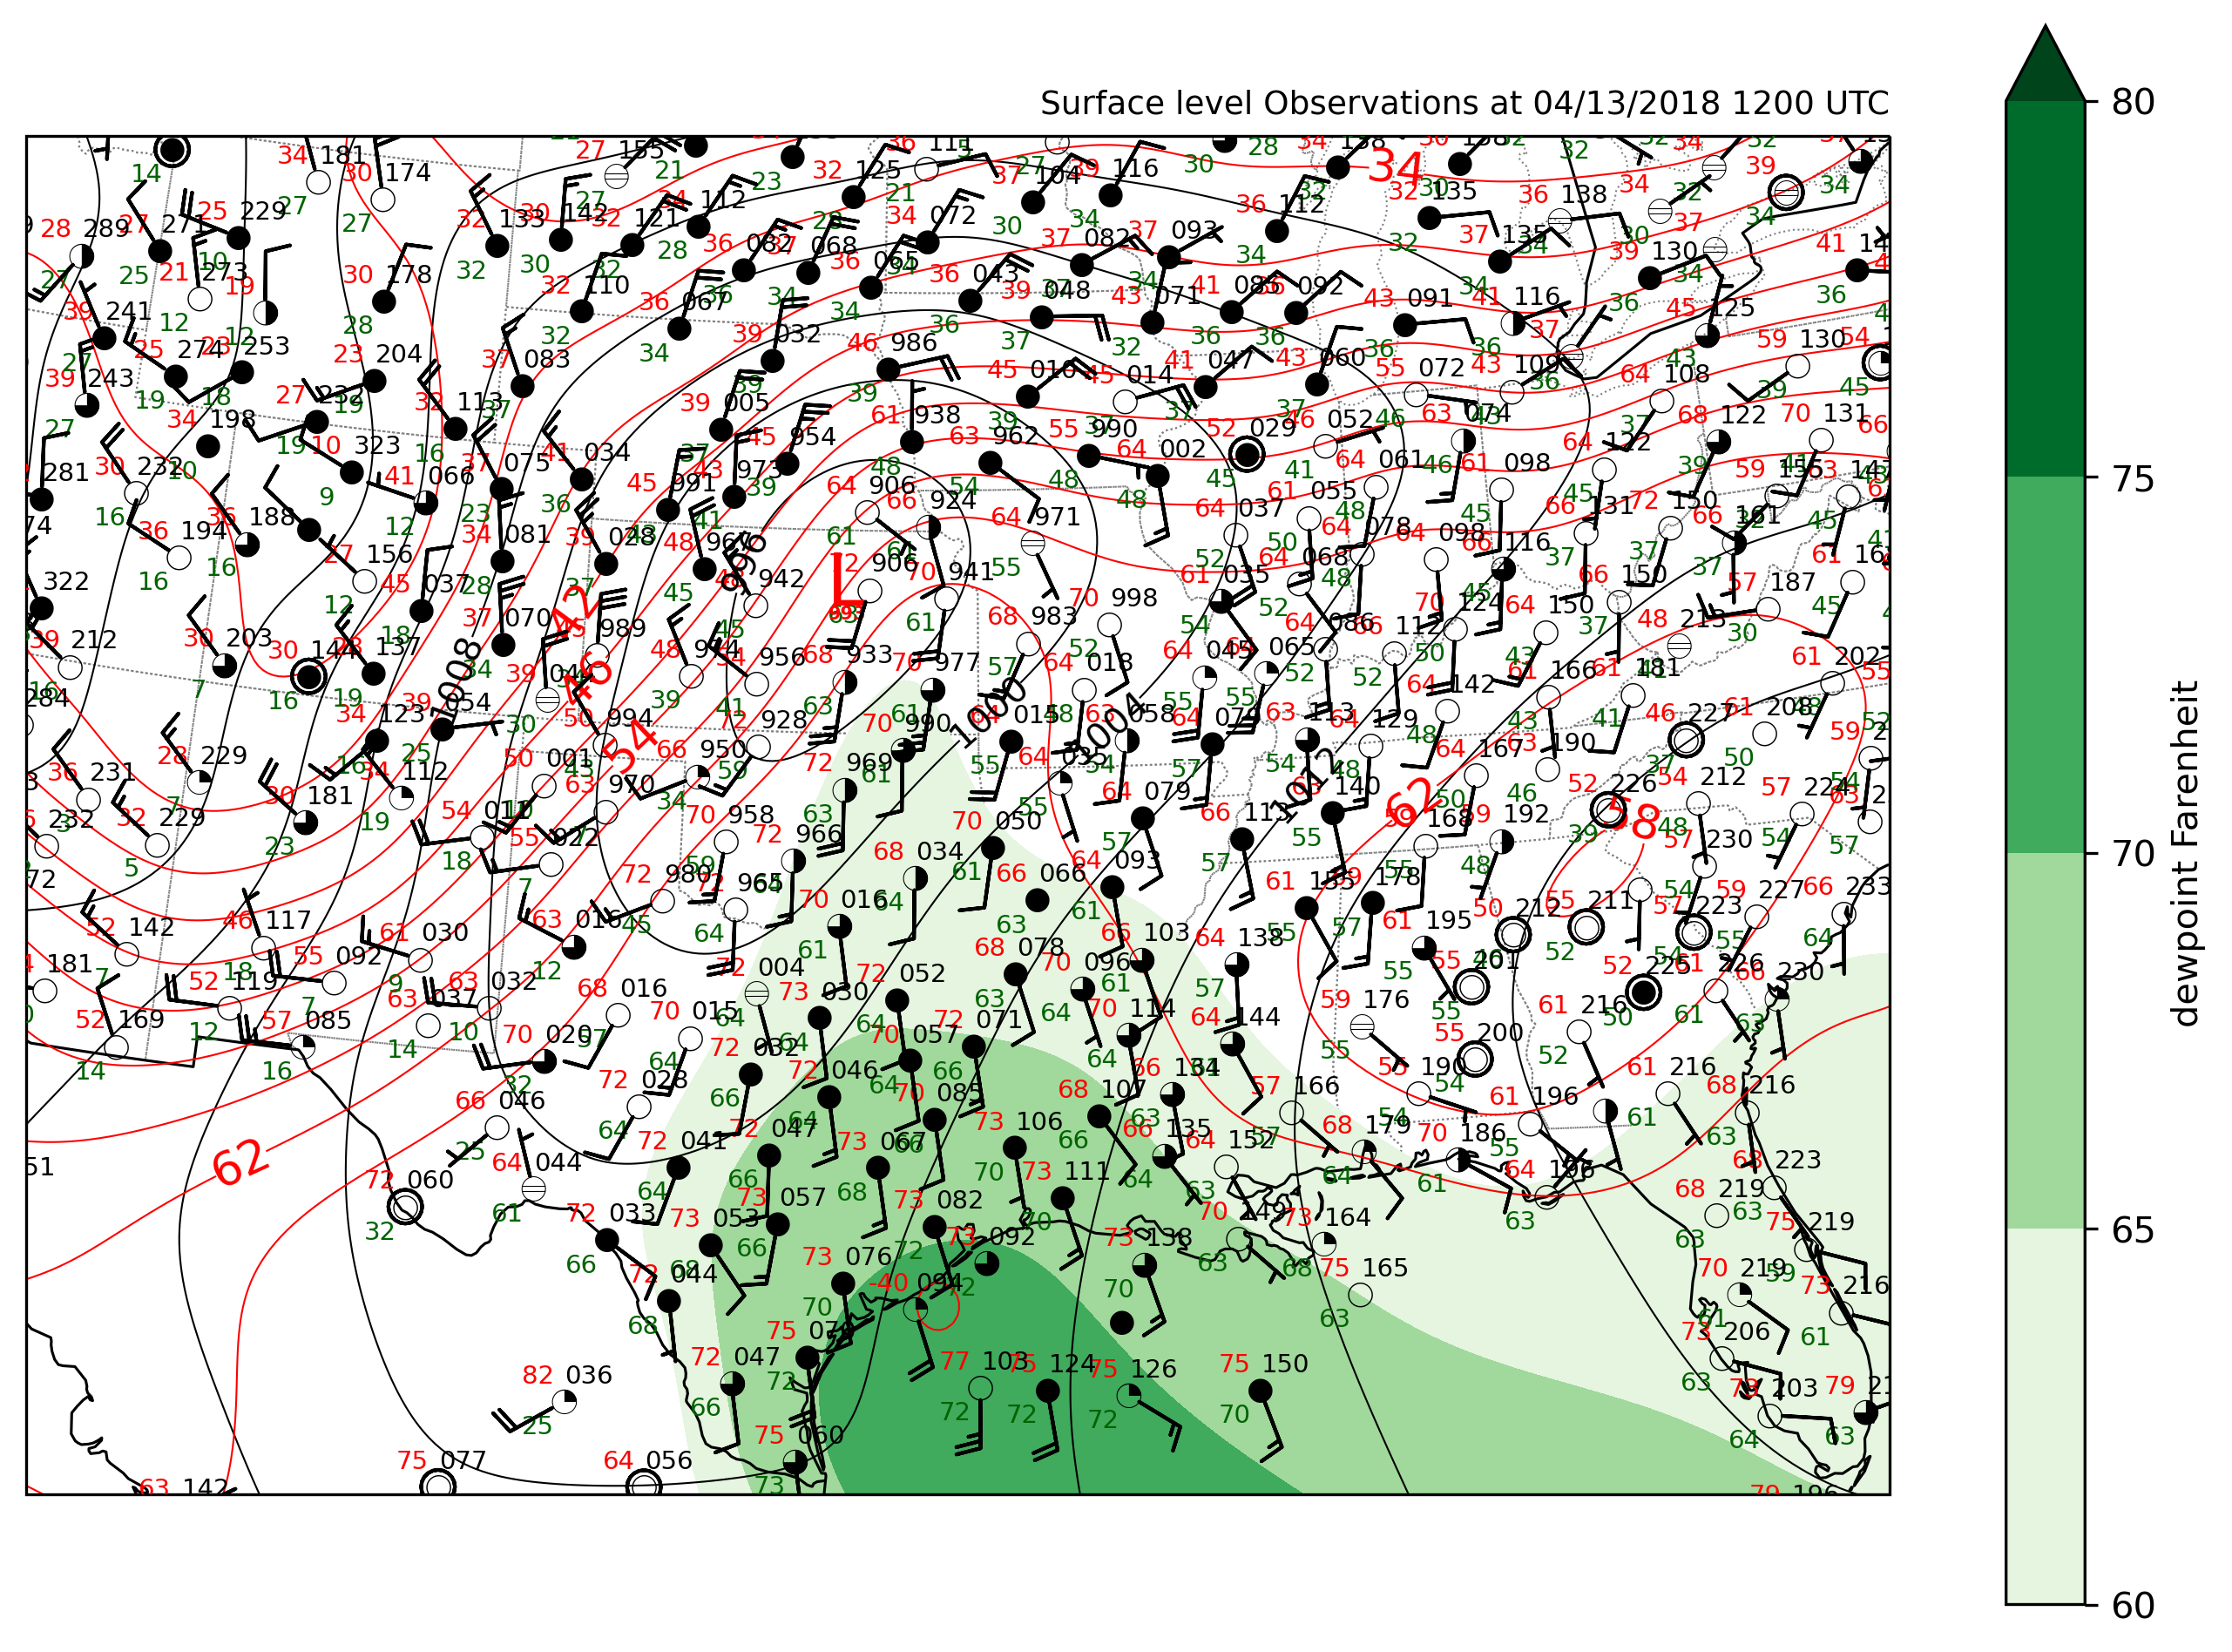

In [7]:
plot_surface(metar_data, time, new_pressure, new_temperature, new_dewpoint, new_lat, new_lon, proj, loc='TX')

<br /><br />
6. Rerun your data processing and plotting function for January 5th, 2022 at 0000 UTC and 1200 UTC with the default location for the plot extent. 

Downloading: 2022-01-05 00:00:00


/opt/tljh/user/lib/python3.7/site-packages/cartopy/crs.py:825: ShapelyDeprecationWarning: __len__ for multi-part geometries is deprecated and will be removed in Shapely 2.0. Check the length of the `geoms` property instead to get the  number of parts of a multi-part geometry.
  if len(multi_line_string) > 1:
/opt/tljh/user/lib/python3.7/site-packages/cartopy/crs.py:877: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  for line in multi_line_string:
/opt/tljh/user/lib/python3.7/site-packages/cartopy/crs.py:944: ShapelyDeprecationWarning: __len__ for multi-part geometries is deprecated and will be removed in Shapely 2.0. Check the length of the `geoms` property instead to get the  number of parts of a multi-part geometry.
  if len(p_mline) > 0:


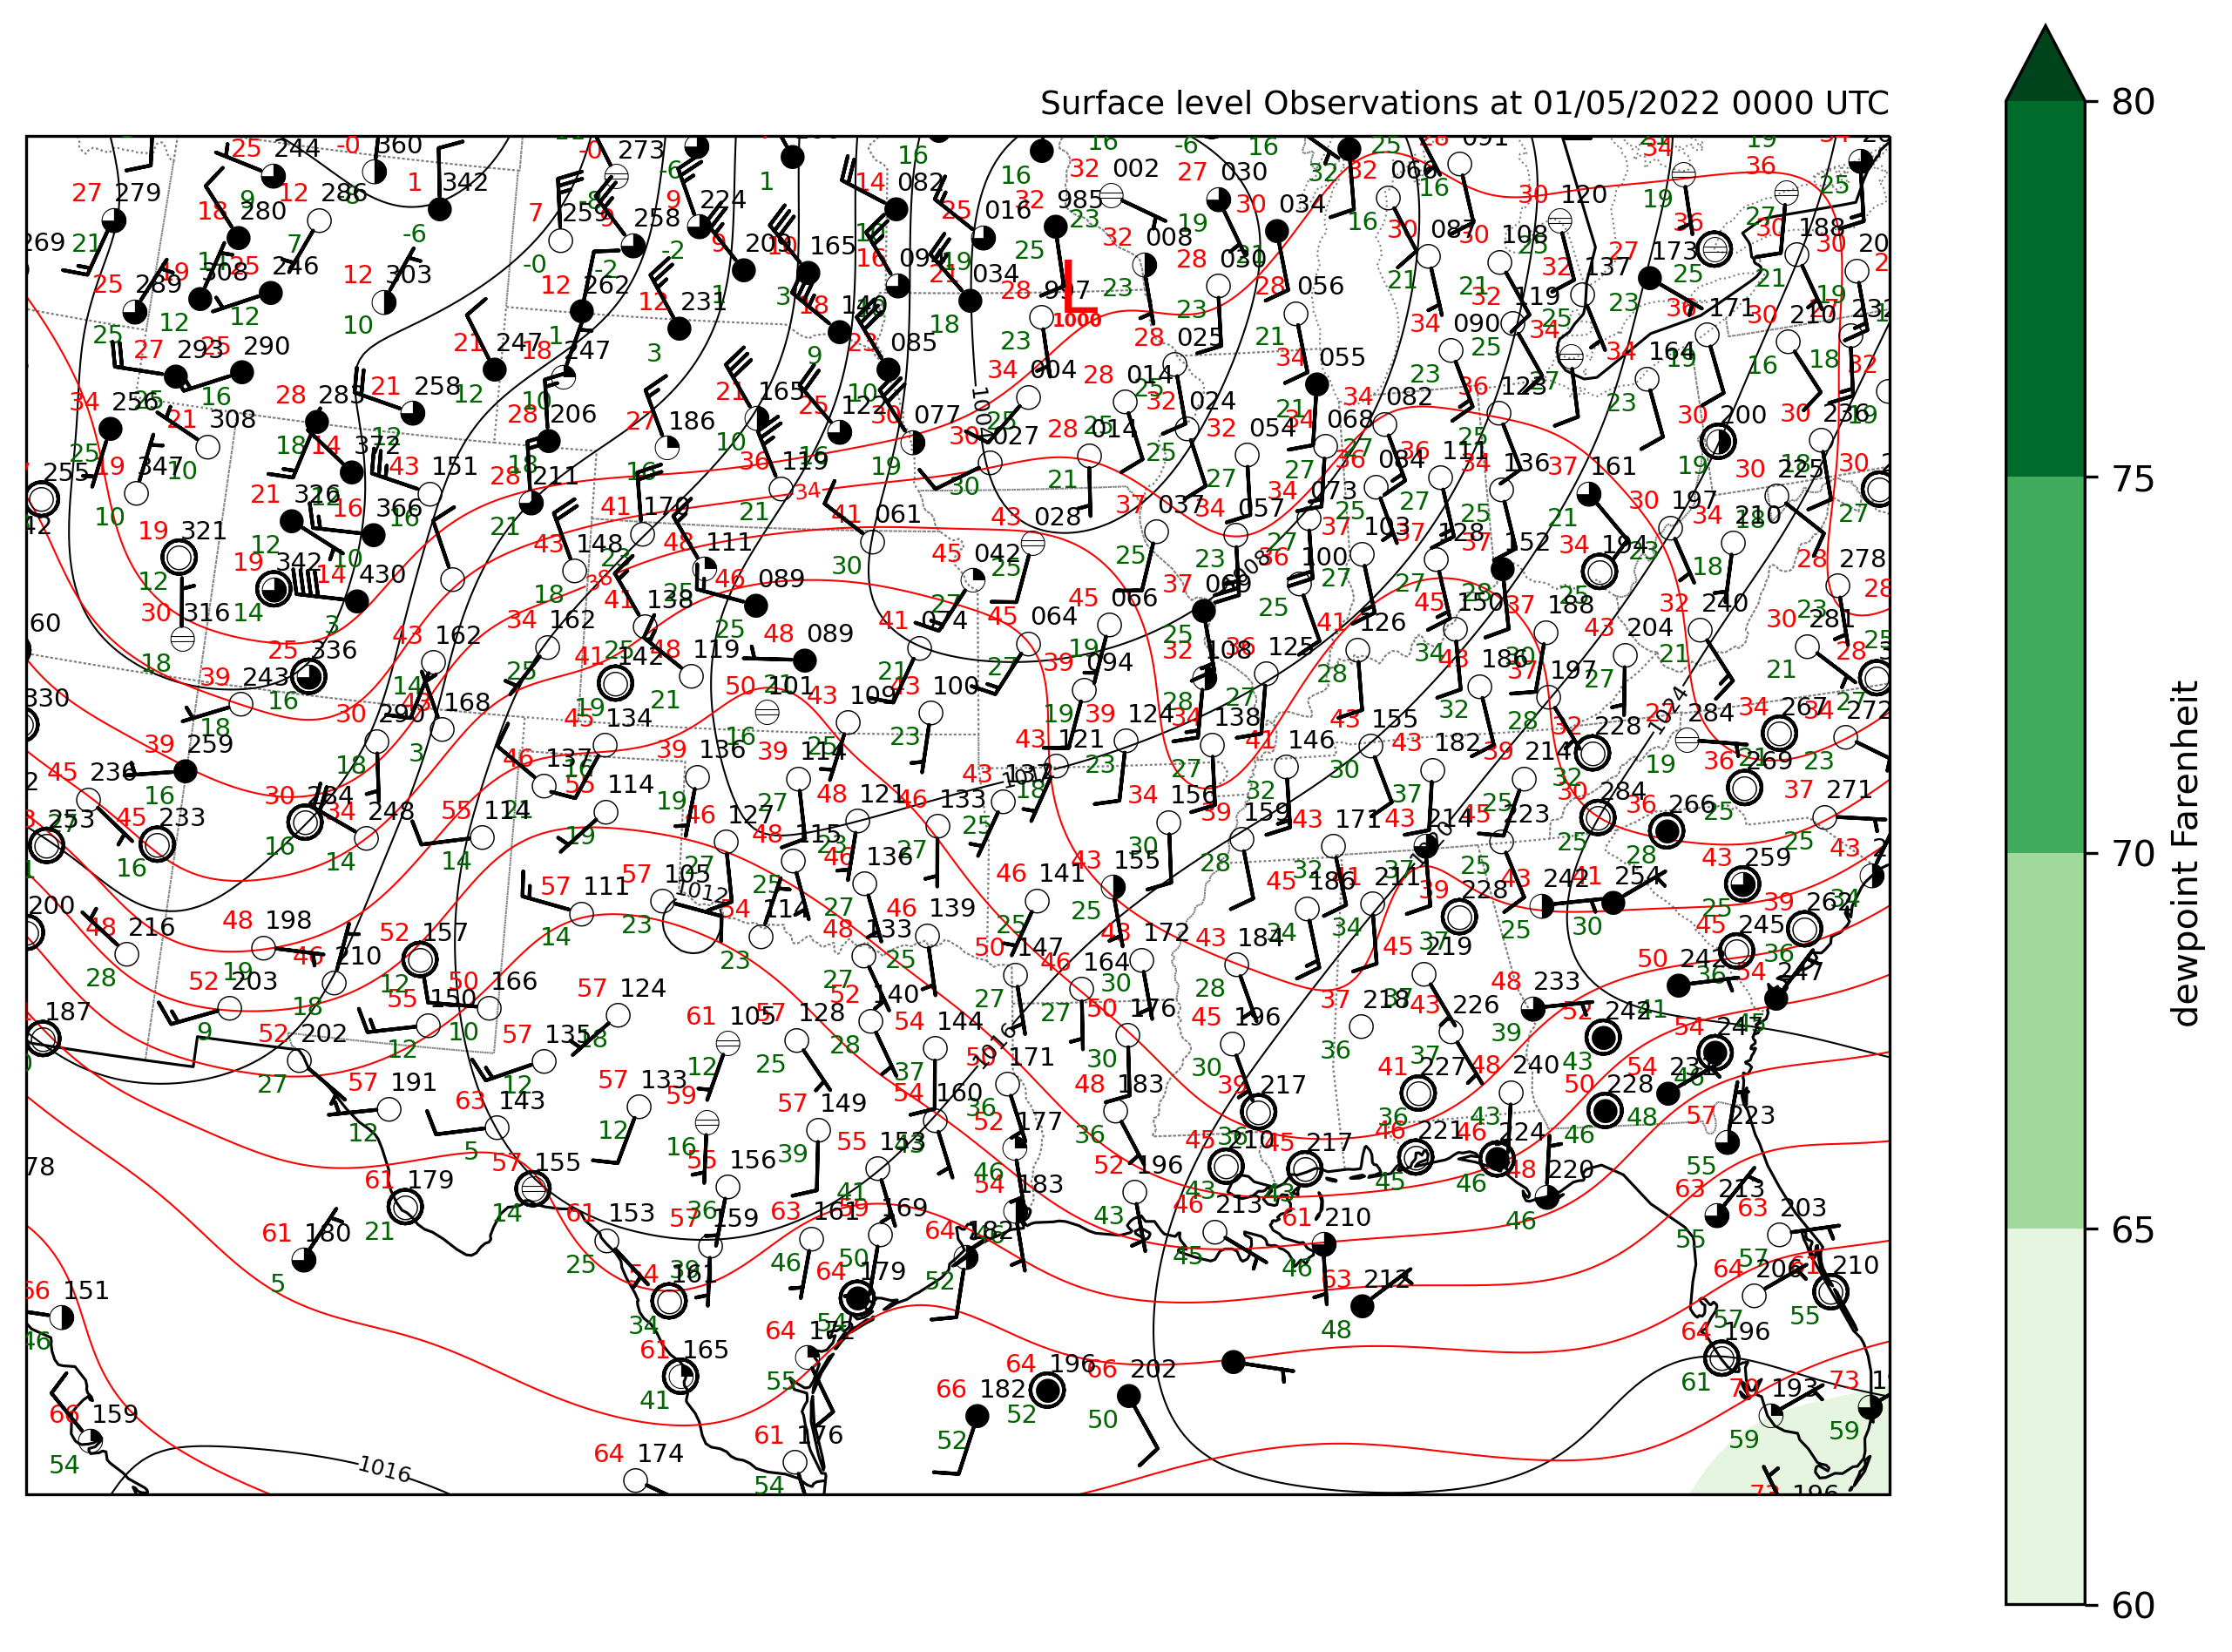

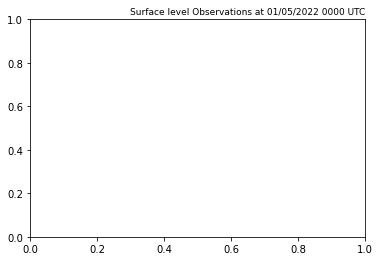

Downloading: 2022-01-05 12:00:00


/opt/tljh/user/lib/python3.7/site-packages/cartopy/crs.py:825: ShapelyDeprecationWarning: __len__ for multi-part geometries is deprecated and will be removed in Shapely 2.0. Check the length of the `geoms` property instead to get the  number of parts of a multi-part geometry.
  if len(multi_line_string) > 1:
/opt/tljh/user/lib/python3.7/site-packages/cartopy/crs.py:877: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  for line in multi_line_string:
/opt/tljh/user/lib/python3.7/site-packages/cartopy/crs.py:944: ShapelyDeprecationWarning: __len__ for multi-part geometries is deprecated and will be removed in Shapely 2.0. Check the length of the `geoms` property instead to get the  number of parts of a multi-part geometry.
  if len(p_mline) > 0:


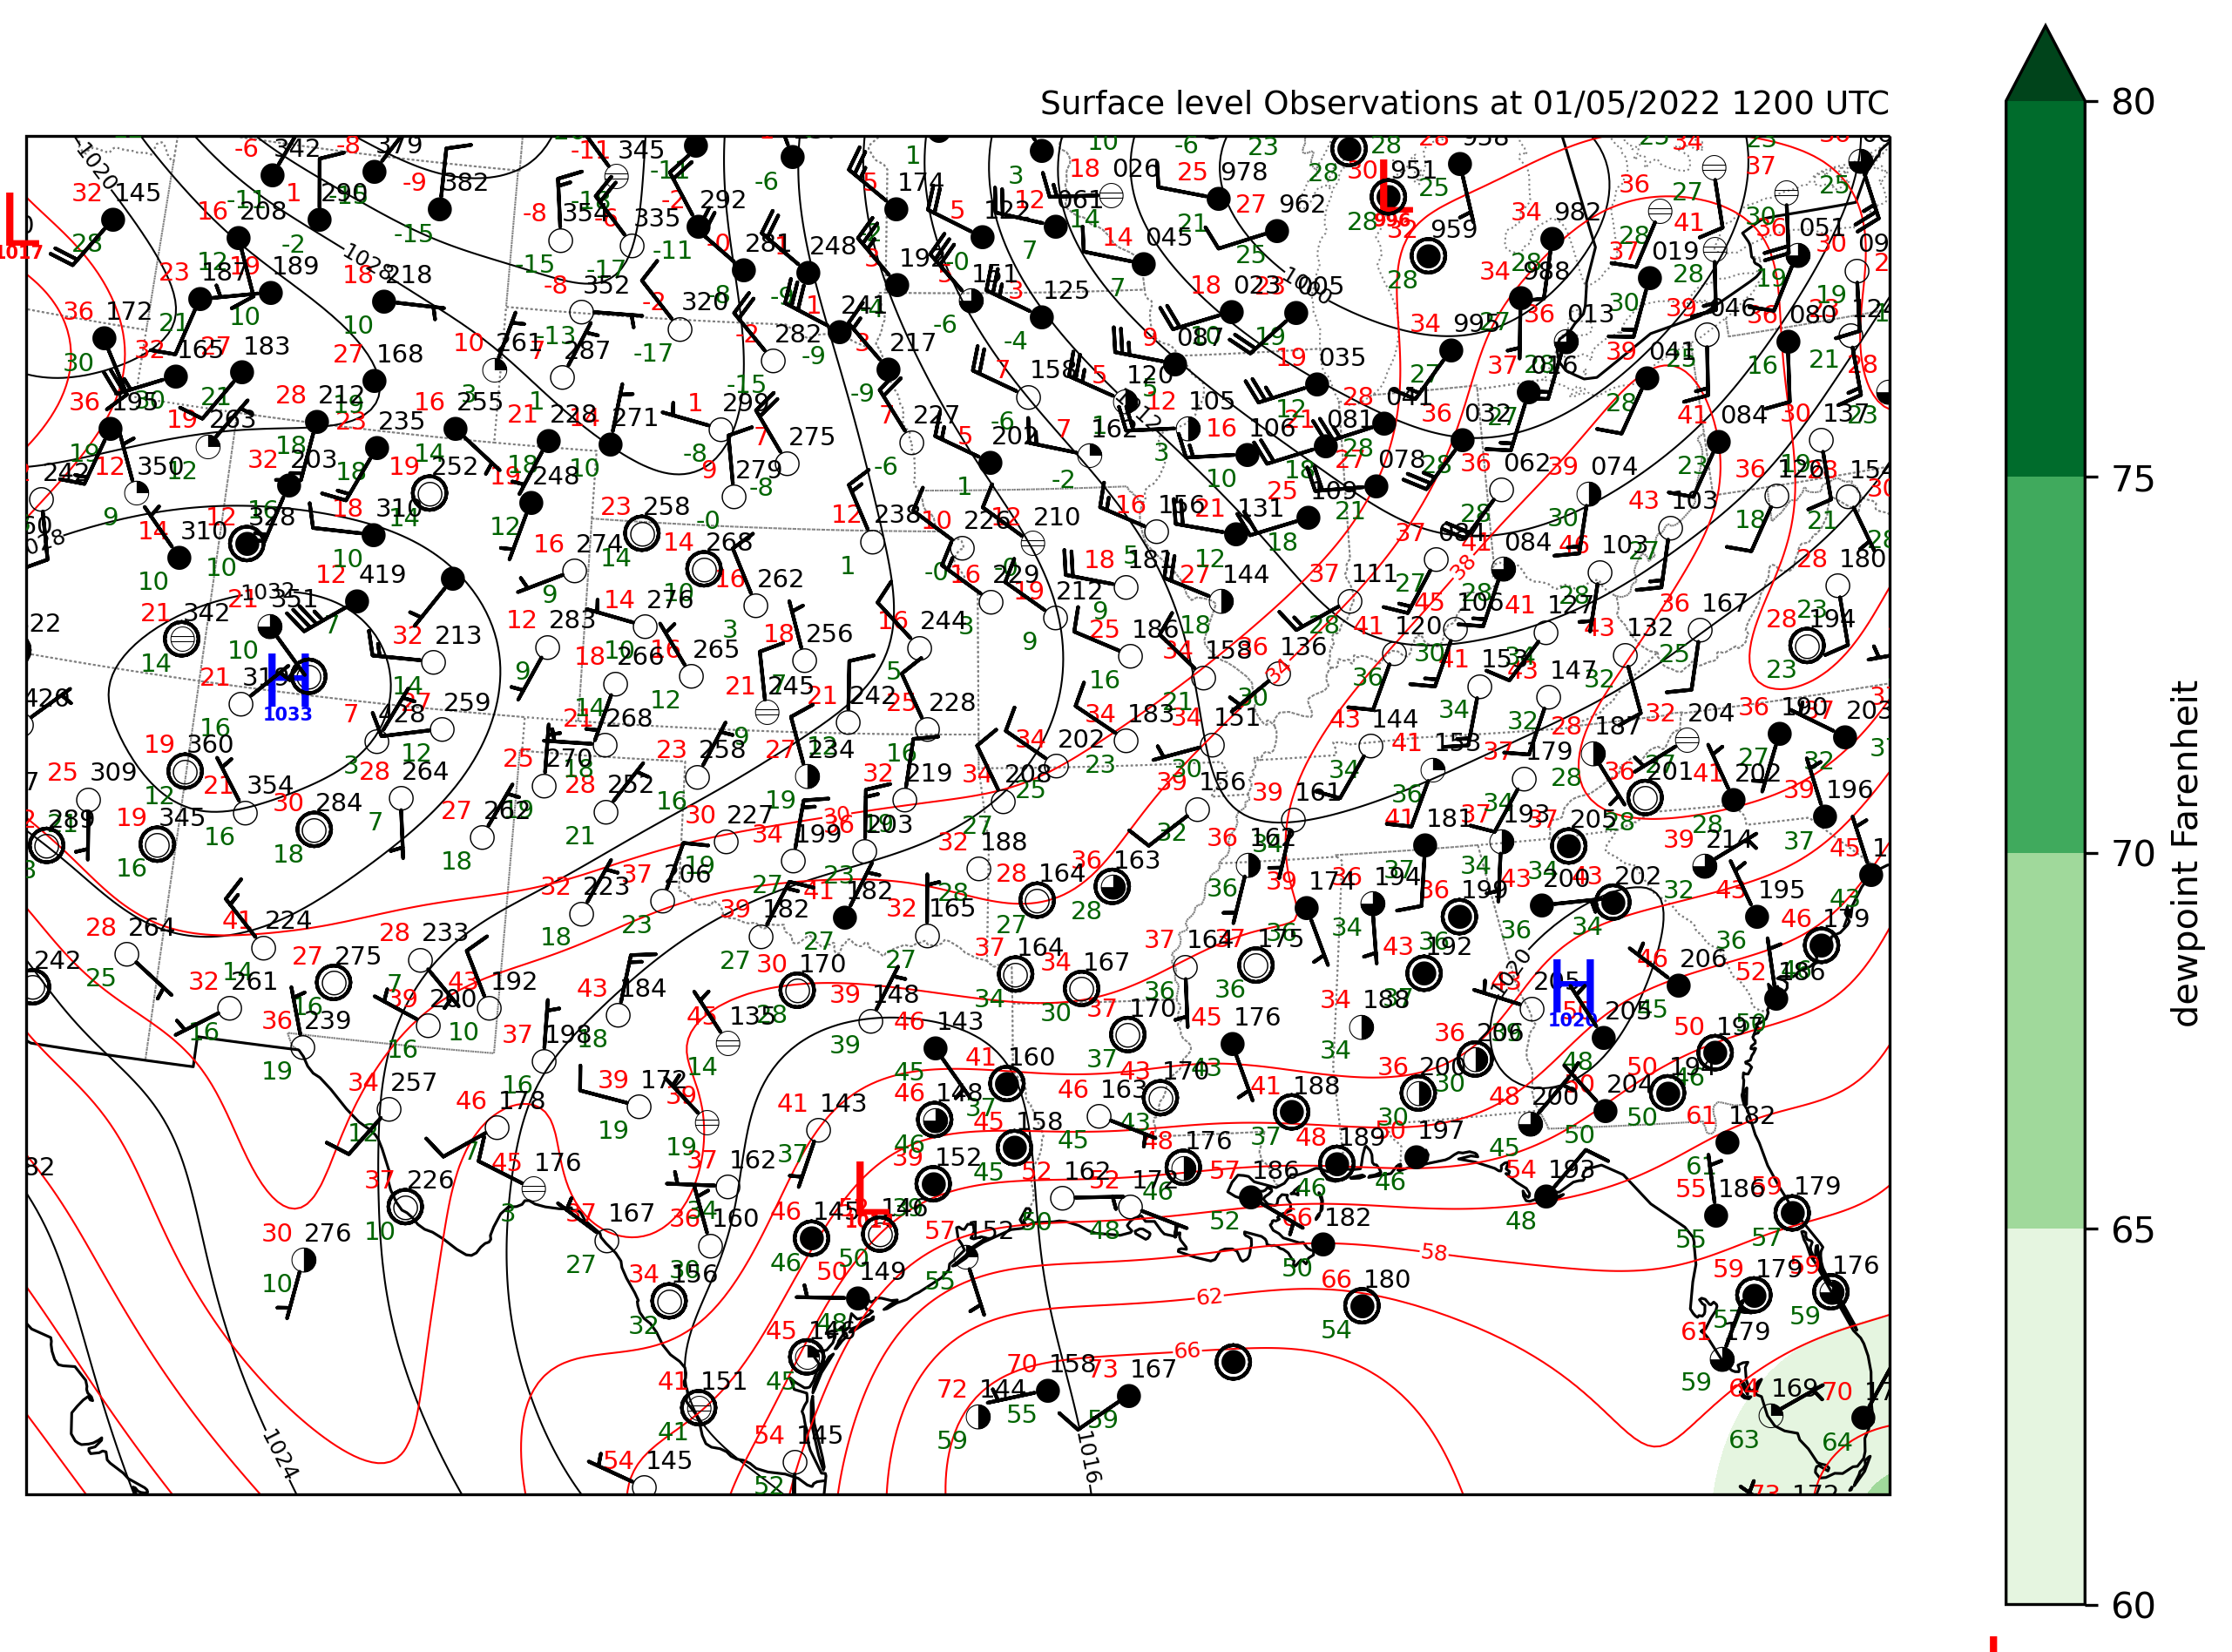

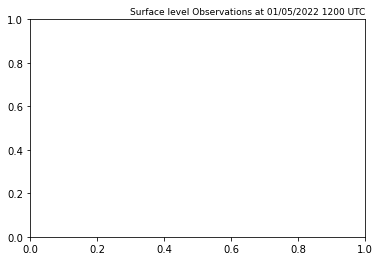

In [23]:
time=datetime(2022,1,5,0)
metar_data, new_pressure,new_temperature, new_dewpoint,new_lat,new_lon, proj = process_surface_data(time)
plot_surface(metar_data, time, new_pressure, new_temperature, new_dewpoint, new_lat, new_lon, proj, loc='TX')
plt.title(f"Surface level Observations at {time:%m/%d/%Y %H%M} UTC",size=9,loc="right")
plt.show() 
time=datetime(2022,1,5,12)
metar_data, new_pressure,new_temperature, new_dewpoint,new_lat,new_lon, proj = process_surface_data(time)
plot_surface(metar_data, time, new_pressure, new_temperature, new_dewpoint, new_lat, new_lon, proj, loc='TX')
plt.title(f"Surface level Observations at {time:%m/%d/%Y %H%M} UTC",size=9,loc="right")
plt.show() 

### You have now completed Part I of the Python portion of the lab.  Be sure to submit the fully rendered Jupyter Notebook on GitHub when you are finished.